# Weather Data Analysis with a public API

In [1]:
import grequests as asynhttp #Peticiones asincronas
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import matplotlib

### Data Collection and Cleaning

In [2]:
capitales = {
    "Africa": ["El Cairo", "Abuya", "Nairobi", "Addis Abeba", "Pretoria"],
    "America": ["Washington D. C.", "Ottawa", "Ciudad de México", "Brasilia", "Buenos Aires",],
    "Asia": ["Pekín", "Tokio", "Nueva Delhi", "Seúl", "Riad"],
    "Europa": ["Madrid", "París", "Berlín", "Roma", "Londres", "A Coruña"],
    "Oceania": ["Canberra", "Wellington", "Port Moresby", "Suva", "Apia"],
}
key="030c86ad50fe0b9ad9817deeb4fc2825"

Usamos la API geo de OpenWeather para obtener la latitud y longitud de cada ciudad por su nombre, y construimos un dataframe. *La documentación insiste en usar este método, el resto están deprecados.*

In [3]:
localizaciones={
    "continente": [],
    "name": [],
    "lat": [],
    "lon": []
}

rs=[]
for continente in capitales:
    for ciudad in capitales[continente]:
        url=f"http://api.openweathermap.org/geo/1.0/direct?q={ciudad}&appid={key}"
        rs.append(asynhttp.get(url))
        localizaciones["continente"].append(continente)
        
futures = asynhttp.map(rs)
for futuro in futures:
    response=futuro.json()    
    localizaciones["name"].append(response[0]["name"])
    localizaciones["lat"].append(response[0]["lat"])
    localizaciones["lon"].append(response[0]["lon"])

In [4]:
df_localizaciones=pd.DataFrame(localizaciones).set_index("name")
df_localizaciones

,continente,lat,lon
name,,,
Cairo,Africa,30.044388,31.235726
Abuja,Africa,9.064331,7.489297
Nairobi,Africa,-1.303264,36.826384
Addis Ababa,Africa,9.010793,38.761252
Pretoria,Africa,-25.745928,28.187910
Washington,America,38.895037,-77.036543
Ottawa,America,45.420878,-75.690111
Mexico City,America,19.432630,-99.133178
Brasília,America,-15.793404,-47.882317


Ahora usamos la API en tiempo real de OpenWeather para obtener el tiempo de cada ciudad. Una vez tenemos todas las respuestas **procesamos el json** para formar un dataframe con la información que nos interesa. 

In [5]:
rs=[]
for entrada in df_localizaciones.values:
    url=f"https://api.openweathermap.org/data/2.5/weather?lat={entrada[1]}&lon={entrada[2]}&appid={key}&units=metric&lang=sp"
    rs.append(asynhttp.get(url))

tiempo=[] 
futures = asynhttp.map(rs)
for futuro in futures:
    tiempo.append(json.loads(futuro.text))

In [6]:
for ciudad in tiempo:
    for i, e in enumerate(ciudad["weather"]):
        del ciudad["weather"][i]["id"]
        del ciudad["weather"][i]["icon"]

In [7]:
df_tiempo = pd.json_normalize(tiempo, "weather", [["main", "temp"], ["main", "feels_like"],
    ["main", "temp_min"],["main", "temp_max"],["main", "pressure"],["main", "humidity"],
    ["main", "sea_level"],["main", "grnd_level"], "visibility", ["wind", "speed"], ["wind", "deg"], 
    ["wind", "gust"], ["rain", "1h"], ["snow", "1h"], ["clouds", "all"], "dt"], sep="-", errors="ignore")

In [8]:
df_tiempo = df_localizaciones.reset_index().join(df_tiempo)

Explorando un poco el dataset, vemos que al convertir el json, no se han *casteado* correctamente los tipos numéricos, al igual que existen valores nulos que deberían ser cero.

In [9]:
df_tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             26 non-null     object 
 1   continente       26 non-null     object 
 2   lat              26 non-null     float64
 3   lon              26 non-null     float64
 4   main             26 non-null     object 
 5   description      26 non-null     object 
 6   main-temp        26 non-null     object 
 7   main-feels_like  26 non-null     object 
 8   main-temp_min    26 non-null     object 
 9   main-temp_max    26 non-null     object 
 10  main-pressure    26 non-null     object 
 11  main-humidity    26 non-null     object 
 12  main-sea_level   26 non-null     object 
 13  main-grnd_level  26 non-null     object 
 14  visibility       26 non-null     object 
 15  wind-speed       26 non-null     object 
 16  wind-deg         26 non-null     object 
 17  wind-gust        1

In [10]:
df_tiempo = df_tiempo.astype({"main-temp": "float", "main-feels_like": "float", "main-temp_min": "float", 
                              "main-temp_max": "float", "main-pressure": "int", "main-humidity": "int",
                              "main-sea_level": "int", "main-grnd_level": "int", "visibility": "int", 
                              "wind-speed": "float", "wind-deg": "int", "wind-gust": "float", 
                              "rain-1h": "float", "snow-1h": "float", "clouds-all": "int"})
df_tiempo["dt"] = pd.to_datetime(df_tiempo["dt"], unit="s", utc=True).dt.tz_convert("Europe/Madrid")

In [11]:
df_tiempo.fillna(0, inplace=True)

In [12]:
df_tiempo.sample(5)

,name,continente,lat,lon,main,description,main-temp,main-feels_like,main-temp_min,main-temp_max,...,main-sea_level,main-grnd_level,visibility,wind-speed,wind-deg,wind-gust,rain-1h,snow-1h,clouds-all,dt
7,Mexico City,America,19.432630,-99.133178,Clouds,nubes dispersas,8.85,8.85,8.85,8.85,...,1017,765,10000,0.74,22,0.73,0.0,0.00,31,2025-12-05 13:02:57+01:00
2,Nairobi,Africa,-1.303264,36.826384,Clouds,muy nuboso,25.05,24.55,25.05,25.75,...,1011,839,10000,10.29,60,0.00,0.0,0.00,75,2025-12-05 13:02:57+01:00
6,Ottawa,America,45.420878,-75.690111,Clouds,algo de nubes,-17.48,-24.02,-17.86,-16.84,...,1025,1012,10000,2.68,179,6.97,0.0,0.00,22,2025-12-05 13:00:25+01:00
5,Washington,America,38.895037,-77.036543,Snow,nevada ligera,-2.08,-6.08,-2.95,-1.20,...,1024,1018,8047,3.09,110,0.00,0.0,0.42,100,2025-12-05 13:02:57+01:00
22,Wellington,Oceania,-41.288795,174.777211,Clouds,nubes,16.54,16.44,15.10,17.95,...,1011,999,10000,9.77,10,0.00,0.0,0.00,98,2025-12-05 13:02:57+01:00


In [13]:
df_tiempo.to_csv("tiempo_global.csv")

### Data Analysis
**Which cities are the hottest and coldest right now?**

In [14]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmax(), ["name", "main-temp"]]

name         Abuja
main-temp    32.14
Name: 1, dtype: object

In [15]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmin(), ["name", "main-temp"]]

name         Ottawa
main-temp    -17.48
Name: 6, dtype: object

**Is there a relationship between temperature and humidity?**

Mostramos un mapa de color de las columnas numéricas más interesantes, podemos ver que la correlación lineal entre humedad es moderada.

In [16]:
df_tiempo.loc[:,["lat", "lon", "main-temp", "main-feels_like", "main-humidity", "main-sea_level", "wind-speed", "wind-gust"]].corr().style.background_gradient(cmap="RdBu", vmin=-1, vmax=1)

,lat,lon,main-temp,main-feels_like,main-humidity,main-sea_level,wind-speed,wind-gust
lat,1.000000,-0.193729,-0.660032,-0.671610,0.184515,0.370057,-0.206979,0.110818
lon,-0.193729,1.000000,0.116971,0.128956,-0.196480,-0.039999,0.036632,-0.212798
main-temp,-0.660032,0.116971,1.000000,0.996465,-0.353755,-0.647442,0.192635,-0.150410
main-feels_like,-0.671610,0.128956,0.996465,1.000000,-0.349639,-0.650134,0.183787,-0.171396
main-humidity,0.184515,-0.196480,-0.353755,-0.349639,1.000000,-0.017643,0.016567,0.001180
main-sea_level,0.370057,-0.039999,-0.647442,-0.650134,-0.017643,1.000000,-0.145586,0.013499
wind-speed,-0.206979,0.036632,0.192635,0.183787,0.016567,-0.145586,1.000000,-0.274964
wind-gust,0.110818,-0.212798,-0.150410,-0.171396,0.001180,0.013499,-0.274964,1.000000


**Which continent seems to have the windiest cities?**

 Para medir esto tenemos dos posibles valores, la velocidad de las rachas de viento y del viento en general. Creo que es más acertado considerar más las rachas(gust), ya que son el efecto del viento más molesto para las personas.

In [17]:
df_tiempo.groupby("continente")["wind-gust"].max().sort_values(ascending=False)

continente
America    6.97
Europa     4.92
Oceania    3.66
Asia       3.47
Africa     3.26
Name: wind-gust, dtype: float64

In [18]:
df_tiempo.groupby("continente")["wind-speed"].max().sort_values(ascending=False)

continente
Africa     10.29
Oceania     9.77
Europa      5.66
America     5.14
Asia        4.12
Name: wind-speed, dtype: float64

**What’s the most common weather description (e.g., clear, cloudy, rainy)?**

In [19]:
df_tiempo.value_counts("main")

main
Clouds    16
Clear      5
Mist       2
Haze       1
Rain       1
Snow       1
Name: count, dtype: int64

### Visualization
Realizaremos dos visualizaciones:
1. Una de correlaciones interesantes.
2. Una segunda de temperatura por ciudad y continente.

<Axes: xlabel='Humedad(%)', ylabel='Temp(Cº)'>

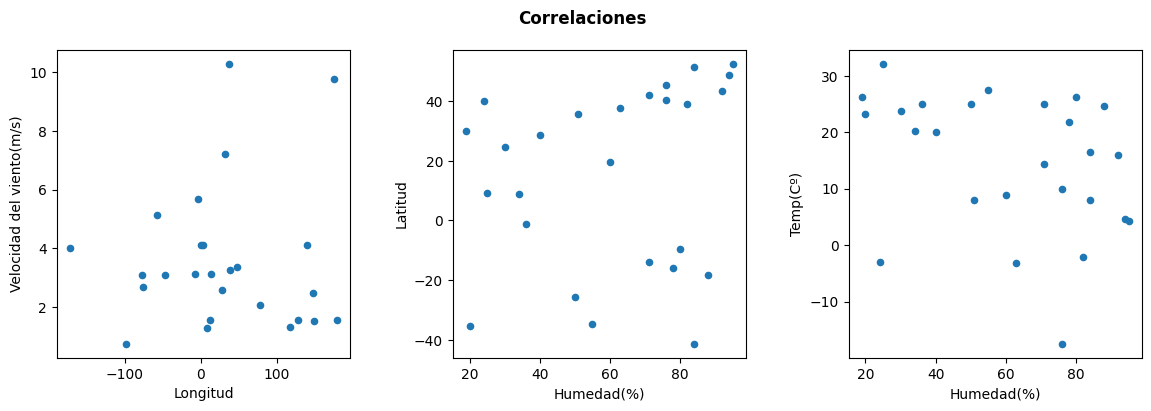

In [20]:
fig,axs = plt.subplots(1,3, figsize=(14,4))
fig.suptitle("Correlaciones", weight="bold")
plt.subplots_adjust(wspace=0.35)
df_tiempo.loc[:,["wind-speed","lon"]].plot.scatter(ax=axs[0], x="lon", y="wind-speed", xlabel="Longitud", ylabel="Velocidad del viento(m/s)")
df_tiempo.loc[:,["main-humidity","lat"]].plot.scatter(ax=axs[1], x="main-humidity", y="lat", xlabel="Humedad(%)", ylabel="Latitud")
df_tiempo.loc[:,["main-temp", "main-humidity"]].plot.scatter(ax=axs[2], x="main-humidity", y="main-temp", xlabel="Humedad(%)", ylabel="Temp(Cº)")

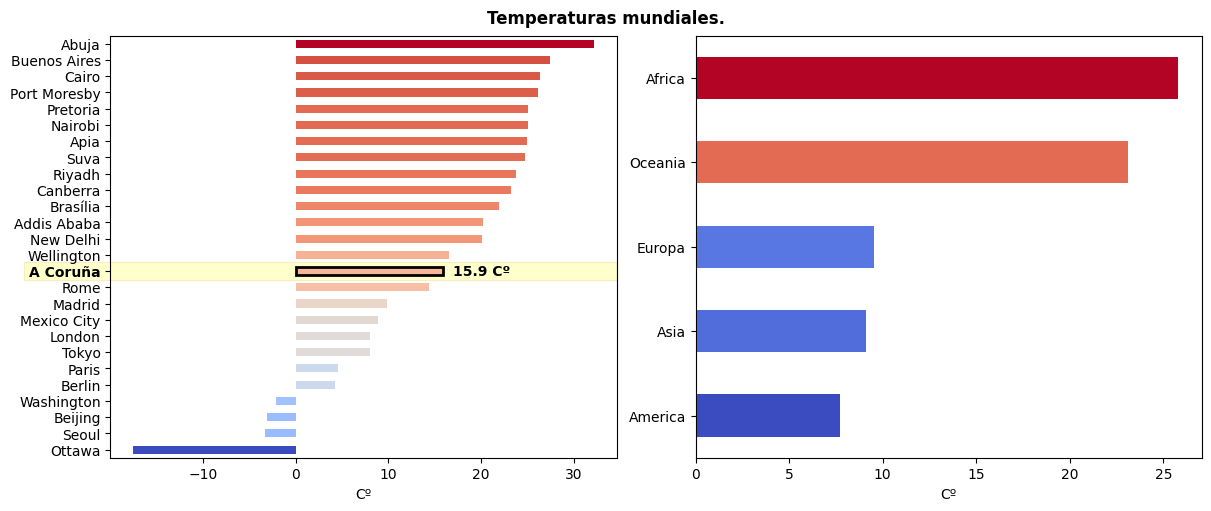

In [27]:
fig,axs = plt.subplots(1,2, figsize=(12, 5), constrained_layout=True)
fig.suptitle("Temperaturas mundiales.", weight="bold")

s_temp=df_tiempo.set_index("name").loc[:,"main-temp"].sort_values() # Importante que esto sea una Serie
norm = matplotlib.colors.Normalize(vmin=s_temp.min(), vmax=s_temp.max())
colors = plt.get_cmap("coolwarm")(norm(s_temp.values))
bars = s_temp.plot.barh(ax=axs[0], color=colors, xlabel="Cº", ylabel="")
is_coruña = "A Coruña" in s_temp.index

s_temp2=df_tiempo.groupby("continente")["main-temp"].mean().sort_values()
norm = matplotlib.colors.Normalize(vmin=s_temp2.min(), vmax=s_temp2.max())
colors = plt.get_cmap("coolwarm")(norm(s_temp2.values))
s_temp2.plot.barh(ax=axs[1], color=colors, xlabel="Cº", ylabel="")

#forzamos el renderizado para que los calculos sean sobre objetos y una figura que existen.
fig.canvas.draw() 

if is_coruña:
    i = list(s_temp.index).index("A Coruña")
    bar = axs[0].patches[i]
    label = axs[0].get_yticklabels()[i]
    bar.set_linewidth(2)
    bar.set_edgecolor("black")
    label.set_fontweight("bold")

    axs[0].text(
        bar.get_width()+ 1,
        bar.get_y(),
        f"{bar.get_width():.1f} Cº",
        fontsize=10,
        fontweight="semibold",
        color="black",
    )
    
    lbl_disp = label.get_window_extent()
    bar_disp = bar.get_window_extent()
    ax_disp = axs[0].get_window_extent()
    padding=5
    highlight = matplotlib.transforms.Bbox.from_extents(lbl_disp.x0-padding, bar_disp.y0-padding,
                                  ax_disp.x1, bar_disp.y1+padding)
    
    highlight = highlight.transformed(fig.transFigure.inverted())
    x0, y0, w, h = highlight.x0, highlight.y0, highlight.width, highlight.height
    rect = matplotlib.patches.Rectangle(
        (x0, y0), w, h,
        transform=fig.transFigure,
        facecolor="yellow",
        alpha=0.2,
        edgecolor="goldenrod",
        linewidth=0.8,
        clip_on=False,
        zorder=0.1,
    )
    axs[0].add_patch(rect)

plt.show()

### Summary
Los datos que vemos son los esperados en esta época del año (11 de diciembre), destacar que la mayor correlación de los valores es con la latitud y longitud; siendo poca por ejemplo entre humedad y temperatura. Aunque la valoración de **los datos a nivel global, hace que se difumine la especificidad y la localidad del clima**, la diferencia entre ambos hemisferios es palpable

Por terminar, me he chocado con dos problemas que me han consumido gran cantidad del tiempo. La primera es la dificultad para procesas la repsuesta json y encuadrarla tabularmente en un dataframe, la segunda fue a la hora de generar el mapa de color para el gráfico de barras, el comportamiento de este cuando se usa una Serie o un DataFrame es muy diferente.

Un detalle a tener en cuenta sobre la API es que *durante la madrugada deja de sincronizarse*.